КЛАСТЕРИЗАЦИЯ ПОВЕДЕНИЯ ПОЛЬЗОВАТЕЛЕЙ. 


Основной вопрос: Существуют ли различные типы пользовательского рекламного поведения, и можно ли выделить их с помощью кластеризации поведенческих признаков?

В статье был предложен опыт разделения пользователей на кластеры по схожим привычкам просмотра рекламы. Ниже использована RMF-система. На основе этих признаков пользователи были сгруппированы с помощью алгоритмов кластеризации, что позволило выделить характерные «персоны». Далее проведён анализ демографии и построены визуализации результатов.

R — Recency (Недавность): насколько недавно пользователь совершил просмотр рекламы(на самом деле, целевое действие может быть другим, поскольку задач в рекламе достаточно много).

F — Frequency (Частота): как часто пользователь видит рекламу за определённый период.

M — Monetary (Денежная ценность / Вклад): сколько пользователь «принёс» - количество показов рекламы.

In [103]:
!pip install -q catboost


[notice] A new release of pip is available: 24.2 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [58]:
pip install scikit-learn seaborn matplotlib pandas numpy scipy


[notice] A new release of pip is available: 24.2 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


from scipy import stats
from scipy.stats import chi2_contingency, kruskal

In [60]:
users = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/users.tsv", sep="\t")
history = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/history.tsv", sep="\t")
validate = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate.tsv", sep="\t")

answers = pd.read_csv("/Users/samsanovicekaterina/dl.25/data/validate_answers.tsv", sep="\t")


In [61]:
history

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148
...,...,...,...,...
1147852,382,45.00,1,7871
1147853,360,33.35,1,7992
1147854,381,205.00,1,21516
1147855,383,37.50,1,8224


In [65]:
def compute_user_campaign_stats(user_history: pd.DataFrame) -> dict:
    total_impressions = len(user_history)
    unique_campaigns = user_history['publisher'].nunique()
    
    campaign_counts = user_history['publisher'].value_counts()
    
    avg_impressions_per_campaign = (
        total_impressions / unique_campaigns if unique_campaigns > 0 else 0
    )
    
    max_impressions_single_campaign = campaign_counts.max() if total_impressions > 0 else 0
    std_impressions_per_campaign = (
        campaign_counts.std() if len(campaign_counts) > 1 else 0
    )
    
    campaign_concentration = (
        max_impressions_single_campaign / total_impressions
        if total_impressions > 0 else 0
    )
    
    impression_variance = (
        campaign_counts.var() if len(campaign_counts) > 1 else 0
    )
    
    return {
        'total_impressions': total_impressions,
        'unique_campaigns': unique_campaigns,
        'avg_impressions_per_campaign': avg_impressions_per_campaign,
        'max_impressions_single_campaign': max_impressions_single_campaign,
        'std_impressions_per_campaign': std_impressions_per_campaign,
        'campaign_diversity': unique_campaigns,
        'campaign_concentration': campaign_concentration,
        'impression_variance': impression_variance
    }


In [66]:
def build_user_behavior_features(history: pd.DataFrame) -> pd.DataFrame:
    user_stats = []

    for user_id in history['user_id'].unique():
        user_history = history[history['user_id'] == user_id]
        stats = compute_user_campaign_stats(user_history)
        stats['user_id'] = user_id
        user_stats.append(stats)

    return pd.DataFrame(user_stats)


In [ ]:
def merge_with_demographics(
    user_features: pd.DataFrame,
    users: pd.DataFrame
) -> pd.DataFrame:
    return user_features.merge(users, on='user_id', how='left')


In [67]:
def engineer_rfm_features(history: pd.DataFrame, users: pd.DataFrame) -> pd.DataFrame:
    
    user_features = build_user_behavior_features(history)
    user_features = merge_with_demographics(user_features, users)
    print(f"columns : {list(user_features.columns)}\n")
    
    feature_cols = [
        'total_impressions',
        'unique_campaigns',
        'avg_impressions_per_campaign',
        'campaign_diversity',
        'campaign_concentration'
    ]

    print(user_features[feature_cols].describe())
    
    return user_features


In [68]:
features = engineer_rfm_features(history, users)
print(features)

columns : ['total_impressions', 'unique_campaigns', 'avg_impressions_per_campaign', 'max_impressions_single_campaign', 'std_impressions_per_campaign', 'campaign_diversity', 'campaign_concentration', 'impression_variance', 'user_id', 'sex', 'age', 'city_id']

       total_impressions  unique_campaigns  avg_impressions_per_campaign  \
count       25536.000000      25536.000000                  25536.000000   
mean           44.950540          1.475172                     32.032134   
std            67.191924          0.712040                     51.183236   
min             1.000000          1.000000                      1.000000   
25%             5.000000          1.000000                      3.600000   
50%            18.000000          1.000000                     12.666667   
75%            58.000000          2.000000                     39.000000   
max          1226.000000          6.000000                   1226.000000   

       campaign_diversity  campaign_concentration  
coun

In [69]:
features

,total_impressions,unique_campaigns,avg_impressions_per_campaign,max_impressions_single_campaign,std_impressions_per_campaign,campaign_diversity,campaign_concentration,impression_variance,user_id,sex,age,city_id
0,54,2,27.000000,52,35.355339,2,0.962963,1250.000000,15661,2,28,68
1,247,2,123.500000,240,164.755880,2,0.971660,27144.500000,8444,1,41,0
2,55,1,55.000000,55,0.000000,1,1.000000,0.000000,15821,1,24,0
3,196,3,65.333333,180,99.485342,3,0.918367,9897.333333,21530,2,17,13
4,153,2,76.500000,77,0.707107,2,0.503268,0.500000,22148,1,23,7
...,...,...,...,...,...,...,...,...,...,...,...,...
25531,1,1,1.000000,1,0.000000,1,1.000000,0.000000,6003,1,33,3
25532,1,1,1.000000,1,0.000000,1,1.000000,0.000000,24131,1,20,95
25533,1,1,1.000000,1,0.000000,1,1.000000,0.000000,12620,1,22,3
25534,1,1,1.000000,1,0.000000,1,1.000000,0.000000,17680,2,38,0


In [ ]:
def prepare_clustering_data(user_features):
    feature_cols = [
        'total_impressions',
        'unique_campaigns', 
        'avg_impressions_per_campaign',
        'max_impressions_single_campaign',
        'campaign_diversity',
        'campaign_concentration'
    ]
    
    X = user_features[feature_cols].values
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, feature_cols, scaler


In [32]:
X_scaled, feature_cols, scaler = prepare_clustering_data(features)
X_scaled


✓ Features selected and scaled


array([[ 0.67924528,  1.        ,  0.40489642,  0.72      ,  1.        ,
        -0.53865577],
       [ 4.32075472,  1.        ,  3.13088512,  4.48      ,  1.        ,
        -0.4121698 ],
       [ 0.69811321,  0.        ,  1.19585687,  0.78      ,  0.        ,
         0.        ],
       ...,
       [-0.32075472,  0.        , -0.32956685, -0.3       ,  0.        ,
         0.        ],
       [-0.32075472,  0.        , -0.32956685, -0.3       ,  0.        ,
         0.        ],
       [-0.32075472,  0.        , -0.32956685, -0.3       ,  0.        ,
         0.        ]], shape=(25536, 6))

In [72]:
def run_kmeans_clustering(X_scaled, min_k=2, max_k=10):
    K_range = range(min_k, max_k+1)
    silhouette_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
    
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal K: {optimal_k}")
    
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans_final.fit_predict(X_scaled)
    
    results = {
        'labels': labels,
        'model': kmeans_final,
        'n_clusters': optimal_k,
        'silhouette': silhouette_score(X_scaled, labels),
        'davies_bouldin': davies_bouldin_score(X_scaled, labels),
        'calinski_harabasz': calinski_harabasz_score(X_scaled, labels)
    }
    
    print(f"Silhouette Score: {results['silhouette']:.4f}")
    print(f"Davies-Bouldin Index: {results['davies_bouldin']:.4f}")
    
    return results


In [73]:
kmeans_results = run_kmeans_clustering(X_scaled)


Optimal K: 3
Silhouette Score: 0.6066
Davies-Bouldin Index: 0.6909


In [74]:
def run_hierarchical_clustering(X_scaled, n_clusters):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = hierarchical.fit_predict(X_scaled)
    
    results = {
        'labels': labels,
        'model': hierarchical,
        'n_clusters': n_clusters,
        'silhouette': silhouette_score(X_scaled, labels),
        'davies_bouldin': davies_bouldin_score(X_scaled, labels)
    }
    
    print(f"{n_clusters} кластера")
    print(f"Silhouette Score: {results['silhouette']:.4f}")
    
    return results


In [75]:
hierarchical_results = run_hierarchical_clustering(X_scaled,n_clusters=kmeans_results['n_clusters'])


3 кластера
Silhouette Score: 0.5848


In [78]:
def run_nmf_clustering(X_scaled, n_components):
    X_nonneg = X_scaled - X_scaled.min() + 0.01 
    nmf = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = nmf.fit_transform(X_nonneg)
    
    labels = np.argmax(W, axis=1)
    
    results = {
        'labels': labels,
        'model': nmf,
        'W': W,
        'n_clusters': n_components,
        'silhouette': silhouette_score(X_scaled, labels),
        'reconstruction_error': nmf.reconstruction_err_
    }
    
    print(f"{n_components} кластера")
    print(f"Silhouette Score: {results['silhouette']:.4f}")
    
    return results


In [80]:
nmf_results = run_nmf_clustering(X_scaled, n_components=kmeans_results['n_clusters'])


3 кластера
Silhouette Score: 0.5773


In [ ]:
clustering_results = {
    'kmeans': kmeans_results,
    'hierarchical': hierarchical_results,
    'nmf': nmf_results
}


Выделение персон 
engagement - вовлеченность. 
diversity - разнообразие.

In [84]:
def assign_persona_names(profiles_df):
    imp_norm = (profiles_df['total_impressions_mean'] - profiles_df['total_impressions_mean'].min()) / \
               (profiles_df['total_impressions_mean'].max() - profiles_df['total_impressions_mean'].min())
    div_norm = (profiles_df['campaign_diversity_mean'] - profiles_df['campaign_diversity_mean'].min()) / \
               (profiles_df['campaign_diversity_mean'].max() - profiles_df['campaign_diversity_mean'].min())
    conc_norm = profiles_df['campaign_concentration_mean']
    
    persona_names = {}
    
    for idx, row in profiles_df.iterrows():
        cid = row['cluster_id']
        imp = imp_norm.iloc[idx]
        div = div_norm.iloc[idx]
        conc = conc_norm.iloc[idx]
        
        if imp>0.7 and div>0.7:
            name = "Champions (High Engagement, High Diversity)"
        elif imp>0.7 and conc>0.5:
            name = "Loyalists (High Engagement, Focused)"
        elif imp>0.5 and div>0.5:
            name = "Active Explorers (Moderate-High Engagement)"
        elif div>0.6:
            name = "Casual Browsers (Diverse, Low Engagement)"
        elif imp<0.3:
            name = "At-Risk (Minimal Engagement)"
        else:
            name = "Potential Users (Moderate Engagement)"
        
        persona_names[cid] = name
    
    return persona_names


In [87]:
def profile_clusters(user_features, clustering_results, method='kmeans'):
    labels = clustering_results[method]['labels']
    user_features['cluster'] = labels
    
    feature_cols = ['total_impressions', 'unique_campaigns', 'avg_impressions_per_campaign',
                    'campaign_diversity', 'campaign_concentration']
    
    cluster_profiles = []
    
    for cluster_id in sorted(user_features['cluster'].unique()):
        cluster_data = user_features[user_features['cluster']==cluster_id]
        profile = {
            'cluster_id': cluster_id,
            'size': len(cluster_data),
            'pct': len(cluster_data)/len(user_features)*100
        }

        for col in feature_cols:
            profile[f'{col}_mean'] = cluster_data[col].mean()
            profile[f'{col}_std'] = cluster_data[col].std()
        
    
        profile['avg_age'] = cluster_data['age'].mean()
        profile['pct_male'] = (cluster_data['sex']==1).mean()*100
        profile['pct_female'] = (cluster_data['sex']==2).mean()*100
        
        cluster_profiles.append(profile)
    
    profiles_df = pd.DataFrame(cluster_profiles)
    
    persona_names = assign_persona_names(profiles_df)
    
    for cid, name in persona_names.items():
        print(f"Cluster {cid}: {name}")
    
    return profiles_df, persona_names, user_features


In [88]:
profiles_df, persona_names, user_features_clean = profile_clusters(features, clustering_results, method='kmeans')


Cluster 0.0: At-Risk (Minimal Engagement)
Cluster 1.0: Loyalists (High Engagement, Focused)
Cluster 2.0: Casual Browsers (Diverse, Low Engagement)


0. Очень низкая вовлечённость, эти пользователи практически не взаимодействуют с рекламой — потенциально теряемая аудитория
1. Высокая вовлечённость, но с концентрацией на конкретных кампаниях. Эти пользователи активны, но "фокусируются" на определённой рекламе.
2. Большое разнообразие кампаний, но вовлечённость ниже предыдущих. Пользователи часто "бегают глазами", но не слишком активно.

Теперь проверим кластеры с демографической точки зрения. 

In [91]:
def analyze_demographics(user_features_clean):
    contingency_sex = pd.crosstab(user_features_clean['cluster'], user_features_clean['sex'])
    chi2_sex, p_sex, _, _ = chi2_contingency(contingency_sex)
    print(f"\nПол(Chi-square p={p_sex:.6f})")
    print(contingency_sex)
    
    age_groups = [user_features_clean[user_features_clean['cluster']==c]['age'].values
                  for c in sorted(user_features_clean['cluster'].unique())]
    h_stat, p_age = kruskal(*age_groups)
    print(f"\nВозраст (Kruskal-Wallis p={p_age:.6f})")
    
    top_cities = user_features_clean['city_id'].value_counts().head(10).index
    city_data = user_features_clean[user_features_clean['city_id'].isin(top_cities)]
    contingency_city = pd.crosstab(city_data['cluster'], city_data['city_id'])
    chi2_city, p_city, _, _ = chi2_contingency(contingency_city)
    print(f"\nГеография (Top 10, Chi-square p={p_city:.6f})")
    
    return {
        'sex_p': p_sex,
        'age_p': p_age,
        'city_p': p_city
    }


In [92]:
analyze_demographics(user_features_clean)



Пол(Chi-square p=0.434971)
sex      0     1     2
cluster               
0        8  9717  8792
1        0  1538  1370
2        1  2211  1899

Возраст (Kruskal-Wallis p=0.000000)

География (Top 10, Chi-square p=0.000000)


{'sex_p': np.float64(0.43497100960475943),
 'age_p': np.float64(3.5406261508969636e-21),
 'city_p': np.float64(1.6630488721155206e-32)}

Пол пользователей не влияет на распределение по кластерам.

Возраст и город значимо связаны с кластером — они реально отражают различия между пользователями, а не случайное разделение.

Визуализация.

In [95]:
labels = user_features_clean['cluster'].values

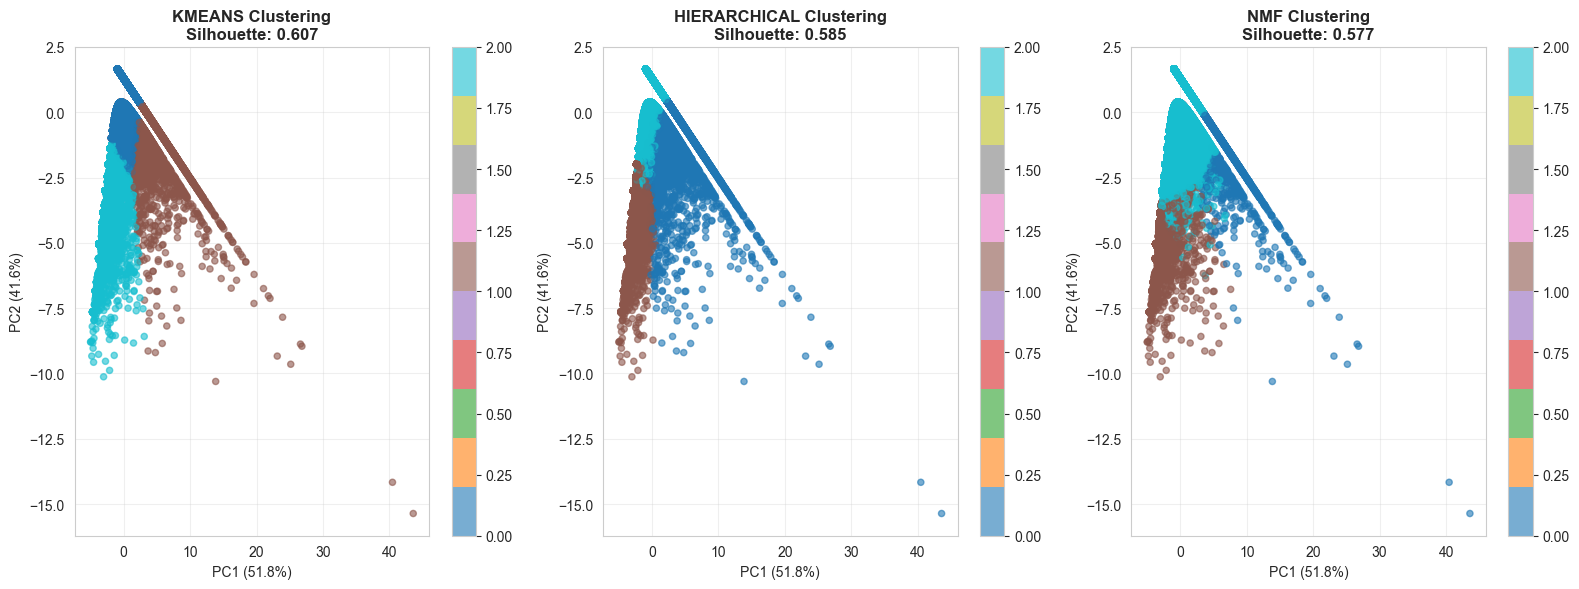

In [98]:
fig1, axes = plt.subplots(1, 3, figsize=(16, 6))

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled[:len(user_features_clean)])

methods = ['kmeans', 'hierarchical', 'nmf']

for idx, method in enumerate(methods):
    ax = axes[idx]
    method_labels = clustering_results[method]['labels']
    
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1], 
        c=method_labels, cmap='tab10', s=20, alpha=0.6
    )
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title(f'{method.upper()} Clustering\nSilhouette: {clustering_results[method]["silhouette"]:.3f}',
                 fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()


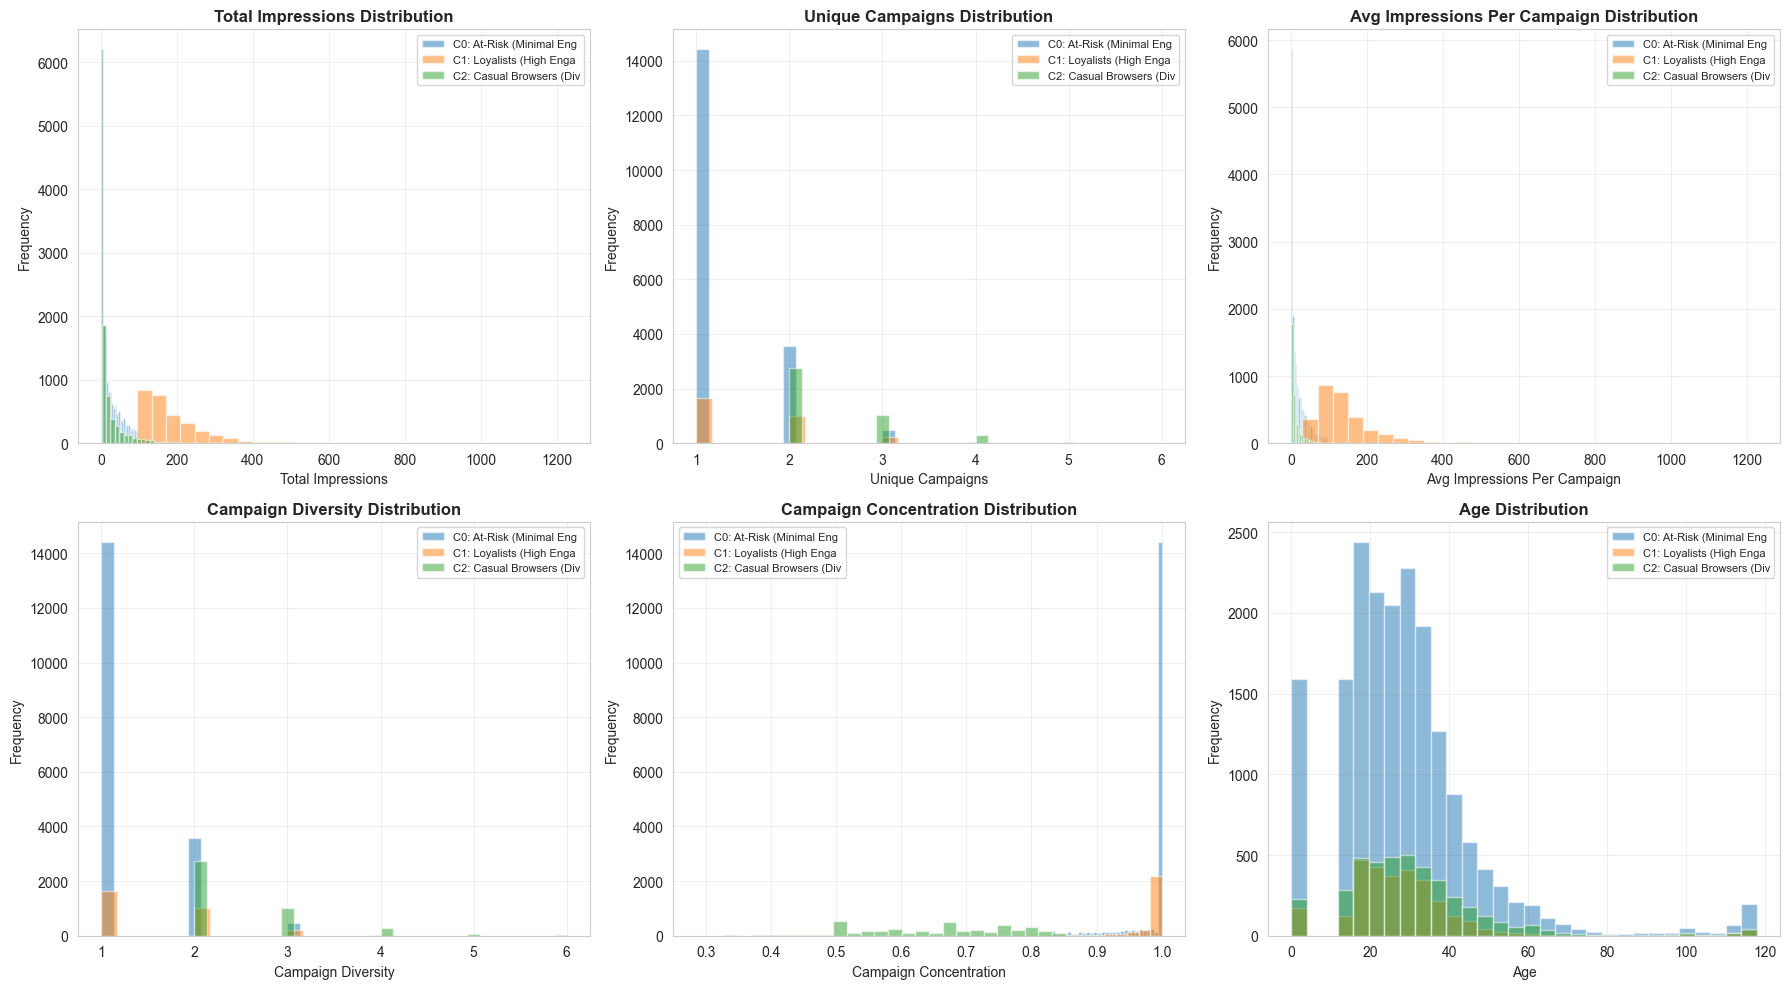

In [99]:
fig2, axes = plt.subplots(2, 3, figsize=(18, 10))

plot_features = ['total_impressions', 'unique_campaigns', 'avg_impressions_per_campaign',
                 'campaign_diversity', 'campaign_concentration', 'age']

for idx, feature in enumerate(plot_features):
    ax = axes[idx // 3, idx % 3]

    for cluster_id in sorted(user_features_clean['cluster'].unique()):
        cluster_data = user_features_clean[user_features_clean['cluster'] == cluster_id][feature]
        ax.hist(cluster_data, alpha=0.5, bins=30, 
                label=f'C{cluster_id}: {persona_names.get(cluster_id, "")[:20]}')

    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution', fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


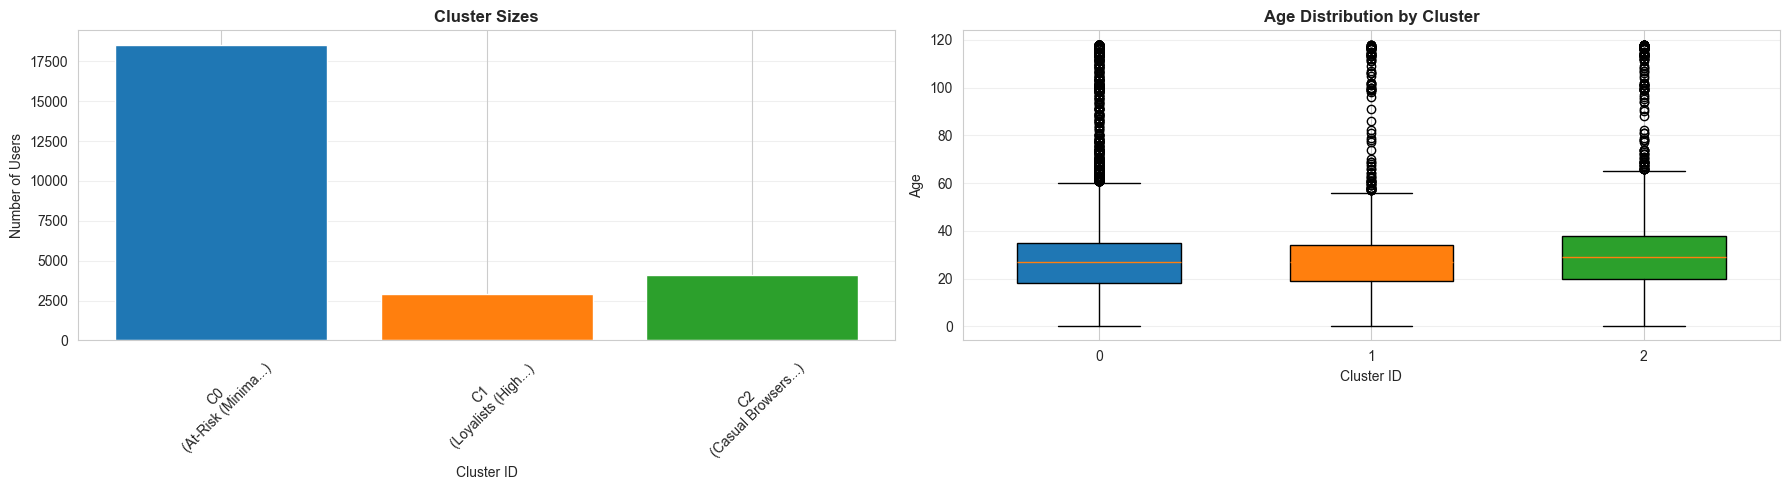

In [ ]:
fig3, axes = plt.subplots(1, 2, figsize=(18, 5))

ax = axes[0]
cluster_sizes = user_features_clean['cluster'].value_counts().sort_index()
colors = plt.cm.tab10(range(len(cluster_sizes)))
ax.bar(range(len(cluster_sizes)), cluster_sizes.values, color=colors)
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Users')
ax.set_title('Cluster Sizes', fontweight='bold', fontsize=12)
ax.set_xticks(range(len(cluster_sizes)))
ax.set_xticklabels([f'C{i}\n({persona_names.get(i, "")[:15]}...)' for i in cluster_sizes.index], rotation=45)
ax.grid(True, alpha=0.3, axis='y')

ax = axes[1]
for cluster_id in sorted(user_features_clean['cluster'].unique()):
    cluster_ages = user_features_clean[user_features_clean['cluster'] == cluster_id]['age']
    ax.boxplot([cluster_ages], positions=[cluster_id], widths=0.6, patch_artist=True,
               boxprops=dict(facecolor=colors[cluster_id % len(colors)]))
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Age')
ax.set_title('Age Distribution by Cluster', fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


С учетом проведенного анализа, в таблицу validate информация о принадлежности каждого user к определенному кластеру представлена в виде долей user, отнесенных к конкретному кластеру. 

In [117]:
cluster_users = {
    cluster_id: set(user_features_clean[user_features_clean['cluster'] == cluster_id]['user_id'].tolist())
    for cluster_id in user_features_clean['cluster'].unique()
}


def compute_cluster_dummies(user_ids_str, cluster_users):
    user_ids = [int(u) for u in user_ids_str.split(',') if u.strip()]
    cluster_features = {}
    
    total_users = len(user_ids)
    if total_users == 0:
        for cid in cluster_users:
            cluster_features[f'cluster_{cid}'] = 0.0
        return cluster_features
    
    for cid, users_in_cluster in cluster_users.items():
        count = sum(1 for u in user_ids if u in users_in_cluster)
        cluster_features[f'cluster_{cid}'] = count / total_users
    
    return cluster_features

validate_clusters = validate['user_ids'].apply(lambda x: compute_cluster_dummies(x, cluster_users))
validate_clusters_df = pd.DataFrame(validate_clusters.tolist())

validate = pd.concat([validate, validate_clusters_df], axis=1)
validate


,cpm,hour_start,hour_end,publishers,audience_size,user_ids,cluster_0,cluster_1,cluster_2
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1...",0.680483,0.101784,0.158447
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3...",0.436232,0.435507,0.126087
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5...",0.668919,0.106982,0.146396
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524...",0.704545,0.095455,0.143182
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2...",0.625339,0.079268,0.197154
...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"2,7,12,15,16",368,"38,50,143,237,456,649,653,698,881,893,1100,127...",0.652174,0.089674,0.163043
1004,90.0,1052,1056,"2,21",484,"1,4,61,212,230,348,356,372,429,431,462,540,593...",0.663223,0.113636,0.126033
1005,122.0,1058,1063,"2,5",704,"1,23,29,104,136,176,201,206,250,269,355,403,44...",0.518466,0.369318,0.110795
1006,138.0,932,1169,"1,2,7",1210,"67,73,80,146,182,202,212,254,307,377,383,385,3...",0.661157,0.081818,0.171074


In [125]:
validate.to_csv('data/validate_new.tsv', sep='\t', index=False)

